In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

In [2]:
T = 23.08 # GeV kinetic energy
# T = 4.54 # GeV kinetic energy ion equivalent of 750 MeV/u
E0 = 0.938 # GeV/c^2 proton rest mass
E = T + E0 # total energy
gamma = E / E0 # gamma
beta = np.sqrt(1-gamma**(-2))
p = E*beta # GeV/c beam momentum

print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p,3)} GeV/c")

gamma = 25.606
beta = 0.999
p = 24.0 GeV/c


In [3]:
# This function changes calculates the new beta functions and the new emittance
def manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, L, scattering=False):
    madx.globals['betx0'] = 'savebeta_air->betx'
    madx.globals['bety0'] = 'savebeta_air->bety'
    madx.globals['alfx0'] = 'savebeta_air->alfx'
    madx.globals['alfy0'] = 'savebeta_air->alfy'
    madx.globals['dx0'] = 'savebeta_air->dx'
    madx.globals['dy0'] = 'savebeta_air->dy'
    madx.globals['dpx0'] = 'savebeta_air->dpx'
    madx.globals['dpy0'] = 'savebeta_air->dpy'

    if scattering==True:
        
        epsilon_0 = exn/(beta*gamma)
        epsilon_0_V = eyn/(beta*gamma)

        p_MeV = p*1000 # Beam total energy in MeV
        q = 1
        P = 1.01325 # Standard air pressure at sea level in Bar
        P_Torr = P*750.062 # Standard air pressure at sea level in Torr
        L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
        L_rad = L_rad0/(P_Torr/760)

        theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

        # Old calculation
        # epsilon_1 = epsilon_0*np.sqrt(1 + (madx.globals['betx0']*theta_rms**2)/epsilon_0)
        # betx0_1 = madx.globals['betx0'] / (np.sqrt(1 + (madx.globals['betx0']*theta_rms**2)/epsilon_0)) 

        # New calculation
        # Horizontal
        gamma0 = (1 + madx.globals['alfx0']**2) / madx.globals['betx0']
        Delta_epsilon = (1/2)*theta_rms**2*(madx.globals['betx0'] + L*madx.globals['alfx0'] + (L**2/3)*gamma0)
        epsilon_1 = epsilon_0 + Delta_epsilon
        alfx0_1 = (epsilon_0*madx.globals['alfx0'] - (L/2)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)
        betx0_1 = (epsilon_0*madx.globals['betx0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)

        # Vertical
        gamma0_V = (1 + madx.globals['alfy0']**2) / madx.globals['bety0']
        Delta_epsilon_V = (1/2)*theta_rms**2*(madx.globals['bety0'] + L*madx.globals['alfy0'] + (L**2/3)*gamma0_V)
        epsilon_1_V = epsilon_0_V + Delta_epsilon_V
        alfy0_1 = (epsilon_0_V*madx.globals['alfy0'] - (L/2)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)
        bety0_1 = (epsilon_0_V*madx.globals['bety0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)


        # Return
        exn = epsilon_1*beta*gamma
        eyn = epsilon_1_V*beta*gamma
        betx0 = betx0_1
        alfx0 = alfx0_1
        bety0 = bety0_1
        alfy0 = alfy0_1
        
    else:
        betx0 = madx.globals['betx0']
        alfx0 = madx.globals['alfx0']
        bety0 = madx.globals['bety0']
        alfy0 = madx.globals['alfy0']
    
    dx0 = madx.globals['dx0']
    dy0 = madx.globals['dy0']
    dpx0 = madx.globals['dpx0']
    dpy0 = madx.globals['dpy0']

    print(f"betx0 = {betx0}")

    return betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn


In [4]:
air_start_pos = 40
air_stop_pos = 60
steps = 1 # meters
inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

### Create the initial sequence and run MAD-X

In [5]:
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input('''

QF : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
QD : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};

AIR_START : MARKER;
AIR_END : MARKER;
END: MARKER;

QF1 : QF, K1 := kQF1;
QD2 : QD, K1 := kQD2;
QF3 : QF, K1 := kQF3;
QD4 : QD, K1 := kQD4;

kQF1 = 0.32730047;
kQD2 = -0.36102915;
kQF3 = 0.32789126;
kQD4 = -0.1991137;

simple_seq: SEQUENCE, refer = exit, l = 100;
QF1 : QF1, AT=2;
QD2 : QD2, AT=5;
QF3 : QF3, AT=8;
QD4 : QD4, AT=11;
''')

# Add the Air region
madx.input(f'''
AIR_START : AIR_START, AT={air_start_pos};
AIR_END : AIR_END, AT={air_stop_pos};
END : END, AT=100;
ENDSEQUENCE;
''')

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

madx.command.beam(particle='PROTON',pc=p,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

True

### Add inner marker at interval between AIR_START and AIR_END markers
### Add hidden markers after the air region

In [6]:
madx.input("SEQEDIT, SEQUENCE = simple_seq;")
# Create a for loop for the inner markers:
marker_names = []
for i in range(len(inner_marker_array)):
    name = "INNER_MARKER"+str(i)
    marker_names.append(name)
for count, pos in enumerate(inner_marker_array):
    madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
    # print(f"INNER_MARKER{str(count)}")
madx.input("ENDEDIT;")


# # Add marker at the end of the line to see the evolution of the beam with fine resolution
# madx.input("SEQEDIT, SEQUENCE = simple_seq;")
# for count, pos in enumerate(np.arange(20, 100, 1)):
#     madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
# madx.input("ENDEDIT;")

True

#### Arriving at first air region AIR_START
* Save beta at AIR_START
* Run the twiss

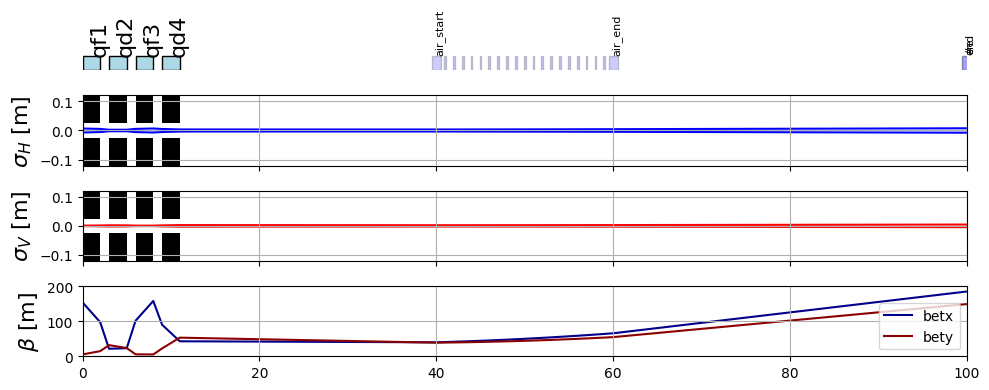

In [7]:
madx.use(sequence="simple_seq")
madx.input("SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE=simple_seq;")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="simple_line.twiss").dframe()
plot_graph(twiss, ex, sige, ey)

In [8]:
def process_scattering(madx, exn, eyn, beta, gamma, marker_names):

    twiss_list = []
    ex_list = []
    ey_list = []

    for i in range(len(marker_names)+1):
        print(i)
        if i == 0:
            print("SAVEBETA at AIR_START")
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=False, L=steps) # SAVEBETA at AIR_START
            
            print(" ")
            print(f"Extracting: SEQUENCE=simple_seq, FROM=AIR_START, TO=END, NEWNAME=seq_air_start_to_end;")
            madx.input("SEQEDIT, SEQUENCE = simple_seq;")
            madx.input("EXTRACT, SEQUENCE=simple_seq, FROM=AIR_START, TO=END, NEWNAME=seq_air_start_to_end;")
            madx.input("ENDEDIT;")
            
            print("SAVEBETA at INNER_MARKER0")
            madx.command.beam(ex=exn/(beta*gamma), ey=eyn/(beta*gamma))
            ex_list.append(madx.sequence.simple_seq.beam.ex)
            ey_list.append(madx.sequence.simple_seq.beam.ey)
            madx.input('BRHO      := BEAM->PC * 3.3356;')

            madx.use(sequence="seq_air_start_to_end")
            madx.input("SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER0, SEQUENCE=seq_air_start_to_end;") # We will SAVEBETA at INNER_MARKER0
            twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe() # Input SAVEBETA at AIR_START
            twiss_list.append(twiss)
            print(twiss.iloc[1].name)
            print()
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=steps)  # SAVEBETA values at INNER_MARKER0 with scattering

            print("")
            print(f"Extracting: SEQUENCE=seq_air_start_to_end, FROM=INNER_MARKER0, TO=END, NEWNAME=seq_inner_marker0_to_end;")
            madx.input("SEQEDIT, SEQUENCE = seq_air_start_to_end;")
            madx.input("EXTRACT, SEQUENCE=seq_air_start_to_end, FROM=INNER_MARKER0, TO=END, NEWNAME=seq_inner_marker0_to_end;")
        if (i!=0 and i<len(marker_names)):
            madx.input(f"SEQEDIT, SEQUENCE = seq_inner_marker{str(i-1)}_to_end;")
            print(f"Extracting: SEQUENCE=seq_inner_marker{str(i-1)}_to_end, FROM=INNER_MARKER{str(i)}, TO=END, NEWNAME=seq_inner_marker{str(i)}_to_end;")
            madx.input(f"EXTRACT, SEQUENCE=seq_inner_marker{str(i-1)}_to_end, FROM=INNER_MARKER{str(i)}, TO=END, NEWNAME=seq_inner_marker{str(i)}_to_end;")
        if (i<len(marker_names)-1):
            madx.input("ENDEDIT;")
            print(f"SAVEBETA at INNER_MARKER{str(i+1)}")

            madx.command.beam(ex=exn/(beta*gamma),ey=eyn/(beta*gamma))
            ex_list.append(madx.sequence.simple_seq.beam.ex)
            ey_list.append(madx.sequence.simple_seq.beam.ey)
            madx.input('BRHO      := BEAM->PC * 3.3356;')

            madx.use(sequence=f"seq_inner_marker{str(i)}_to_end")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER{str(i+1)}, SEQUENCE=seq_inner_marker{str(i)}_to_end;")
            twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
            twiss_list.append(twiss)
            print(twiss.iloc[1].name)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=steps)
            print("")
        if (i==(len(marker_names)-1)):
            madx.input("ENDEDIT;")
            print(f"SAVEBETA at INNER_MARKER{str(i+1)}")

            madx.command.beam(ex=exn/(beta*gamma),ey=eyn/(beta*gamma))
            ex_list.append(madx.sequence.simple_seq.beam.ex)
            ey_list.append(madx.sequence.simple_seq.beam.ey)
            madx.input('BRHO      := BEAM->PC * 3.3356;')

            madx.use(sequence=f"seq_inner_marker{str(i)}_to_end")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END, SEQUENCE=seq_inner_marker{str(i)}_to_end;")
            twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
            twiss_list.append(twiss)
            print(twiss.iloc[1].name)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=steps)
            print("")

        # At the end of the loop, we will extract the last sequence
        if i == len(marker_names):
            madx.input(f"SEQEDIT, SEQUENCE = seq_inner_marker{str(i-1)}_to_end;")
            print(f"Extracting: SEQUENCE=seq_inner_marker{str(i-1)}_to_end, FROM=AIR_END, TO=END, NEWNAME=seq_air_end_to_end;")
            madx.input(f"EXTRACT, SEQUENCE=seq_inner_marker{str(i-1)}_to_end, FROM=AIR_END, TO=END, NEWNAME=seq_air_end_to_end;")
            madx.input("ENDEDIT;")
            print(f"SAVEBETA at AIR_END")


            madx.command.beam(ex=exn/(beta*gamma),ey=eyn/(beta*gamma))
            ex_list.append(madx.sequence.simple_seq.beam.ex)
            ey_list.append(madx.sequence.simple_seq.beam.ey)
            madx.input('BRHO      := BEAM->PC * 3.3356;')

            madx.use(sequence=f"seq_air_end_to_end")
            twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
            twiss_list.append(twiss)
            print(twiss.iloc[1].name)
            print("")

    return twiss_list, ex_list, ey_list

twiss_list, ex_list, ey_list = process_scattering(madx, exn, eyn, beta, gamma, marker_names)

0
SAVEBETA at AIR_START
betx0 = 39.91823813594338
 
Extracting: SEQUENCE=simple_seq, FROM=AIR_START, TO=END, NEWNAME=seq_air_start_to_end;
SAVEBETA at INNER_MARKER0
air_start

betx0 = 37.94125820332989

Extracting: SEQUENCE=seq_air_start_to_end, FROM=INNER_MARKER0, TO=END, NEWNAME=seq_inner_marker0_to_end;
SAVEBETA at INNER_MARKER1
inner_marker0
betx0 = 36.380466436189806

1
Extracting: SEQUENCE=seq_inner_marker0_to_end, FROM=INNER_MARKER1, TO=END, NEWNAME=seq_inner_marker1_to_end;
SAVEBETA at INNER_MARKER2
inner_marker1
betx0 = 35.13565234507367

2
Extracting: SEQUENCE=seq_inner_marker1_to_end, FROM=INNER_MARKER2, TO=END, NEWNAME=seq_inner_marker2_to_end;
SAVEBETA at INNER_MARKER3
inner_marker2
betx0 = 34.14014463546874

3
Extracting: SEQUENCE=seq_inner_marker2_to_end, FROM=INNER_MARKER3, TO=END, NEWNAME=seq_inner_marker3_to_end;
SAVEBETA at INNER_MARKER4
inner_marker3
betx0 = 33.34762785699123

4
Extracting: SEQUENCE=seq_inner_marker3_to_end, FROM=INNER_MARKER4, TO=END, NEWNAME=seq_i

List of twiss needs to be shifted in s position (as they start at 0)

Text(0, 0.5, 'betx [m]')

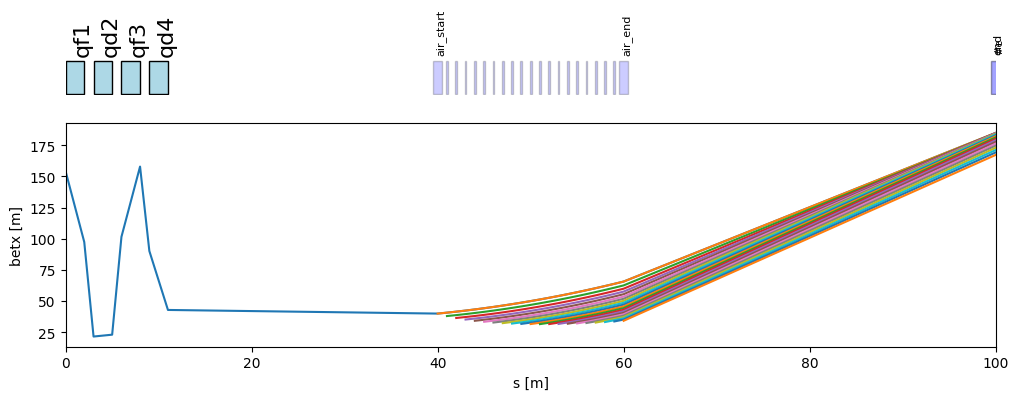

In [9]:
# Shift the s position so that is is coherent.
for i in range(len(twiss_list)):
    twiss_list[i].s = twiss_list[i].s + twiss.loc[twiss_list[i].iloc[1].name].s

# Plot the results
fig, ax = plt.subplots(2,1, figsize=(12, 4), sharex=True, height_ratios=[1, 4])    

draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx)

for i in range(len(twiss_list)):
    ax[1].plot(twiss_list[i].s, twiss_list[i].betx, label=f"twiss {i}")

# ax[1].legend()
ax[1].set_xlabel("s [m]")
ax[1].set_ylabel("betx [m]")

### Add emittances

In [10]:
# We add the emittances to each twiss table
twiss['ex'] = ex_initial

for i in range(len(twiss_list)):
    twiss_list[i]['ex'] = ex_list[i]

twiss['ey'] = ey_initial

for i in range(len(twiss_list)):
    twiss_list[i]['ey'] = ey_list[i]


### Combining the scattering twiss into a single twiss

In [11]:
# We remove the drifts as they are duplicated names
def remove_drift_rows(df):
    df = df.loc[~df.index.str.startswith('drift')]
    df = df.loc[~df.index.str.startswith('#s')]
    return df

twiss_list = [remove_drift_rows(df) for df in twiss_list]

# We combine all the twiss tables into one
def add_missing_rows(df1, df2):
    # Find rows in df1 with lower 's' than the minimum 's' in df2
    missing_rows = df1[df1['s'] < df2['s'].min()]
    
    # Append these rows to df2 and sort by 's'
    df2_updated = pd.concat([df2, missing_rows]).sort_values(by='s')

    return df2_updated

# Loop through each element in the list
for i in range(1, len(twiss_list)):
    twiss_list[i] = add_missing_rows(twiss_list[i-1], twiss_list[i])

# Finaly, we add the initial twiss table to the beginning
twiss_scattered = add_missing_rows(twiss, twiss_list[-1])

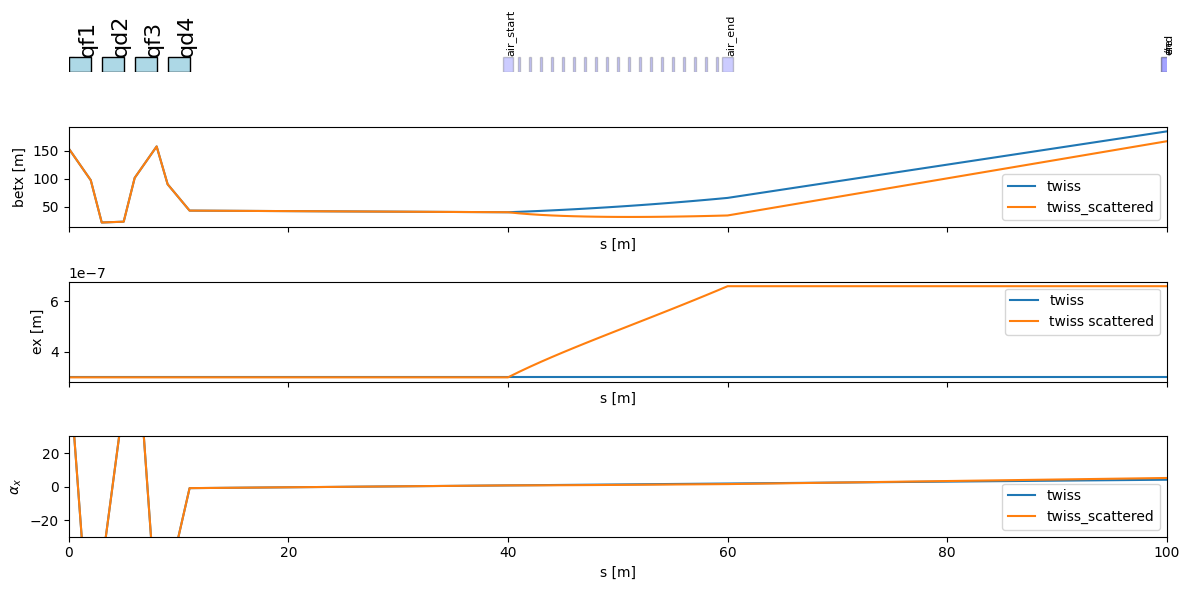

In [12]:
fig, ax = plt.subplots(4,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, 4], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx, label='twiss')
ax[1].plot(twiss_scattered.s, twiss_scattered.betx, label='twiss_scattered')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('betx [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ex, label='twiss')
ax[2].plot(twiss_scattered.s, twiss_scattered.ex, label='twiss scattered')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('ex [m]')
ax[2].legend()

ax[3].plot(twiss.s, -2*twiss.alfx, label='twiss')
ax[3].plot(twiss_scattered.s, -2*twiss_scattered.alfx, label='twiss_scattered')
ax[3].set_xlabel('s [m]')
ax[3].set_ylabel(r'$\alpha_{x}$')
ax[3].set_ylim(-30, 30)
ax[3].legend()

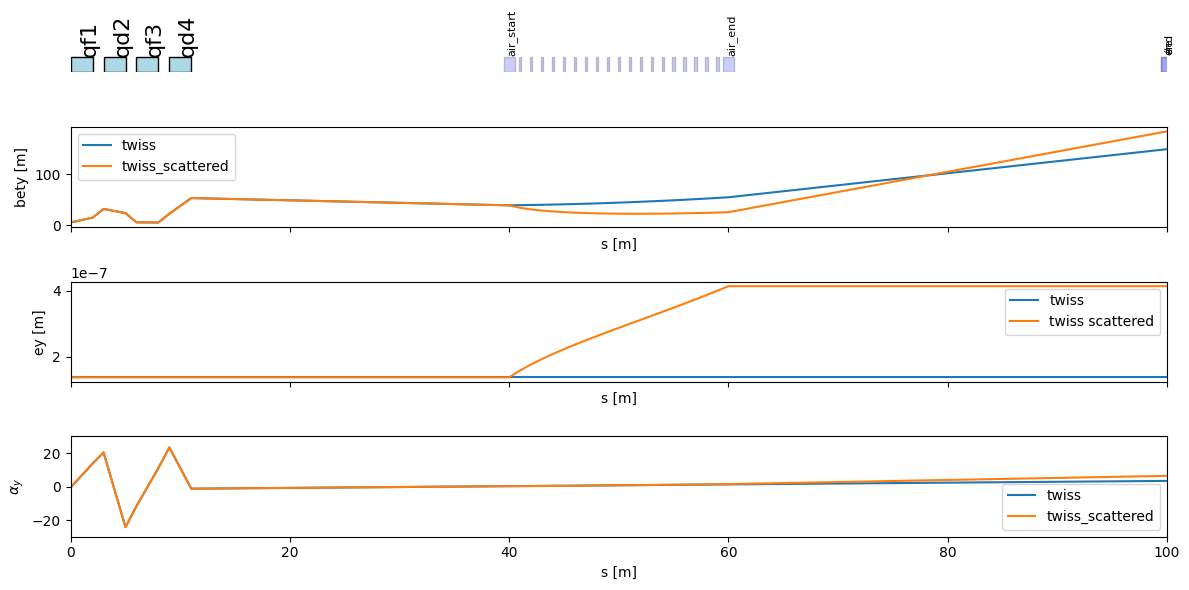

In [13]:
fig, ax = plt.subplots(4,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, 4], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.bety, label='twiss')
ax[1].plot(twiss_scattered.s, twiss_scattered.bety, label='twiss_scattered')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('bety [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ey, label='twiss')
ax[2].plot(twiss_scattered.s, twiss_scattered.ey, label='twiss scattered')
ax[2].set_xlabel('s [m]')
ax[2].set_ylabel('ey [m]')
ax[2].legend()

ax[3].plot(twiss.s, -2*twiss.alfy, label='twiss')
ax[3].plot(twiss_scattered.s, -2*twiss_scattered.alfy, label='twiss_scattered')
ax[3].set_xlabel('s [m]')
ax[3].set_ylabel(r'$\alpha_{y}$')
ax[3].set_ylim(-30, 30)
ax[3].legend()

In [14]:
fig, ax = plt.subplots(3,1, figsize=(12, 6), sharex=True, height_ratios=[1, 4, 4, ], tight_layout=True)
draw_synoptic(ax[0], twiss)
ax[1].plot(twiss.s, twiss.betx, ls="--", c="b", label=r'$\beta_{x}$ vacuum')
ax[1].plot(twiss.s, twiss.bety, ls="--", c="r", label=r'$\beta_{y}$ vacuum')
ax[1].plot(twiss_scattered.s, twiss_scattered.betx, c="b", label=r'$\beta_{x}$ scattering')
ax[1].plot(twiss_scattered.s, twiss_scattered.bety, c="r", label=r'$\beta_{y}$ scattering')
ax[1].set_ylabel(r'$\beta$ [m]')
ax[1].legend()

ax[2].plot(twiss.s, twiss.ex, ls="--", c="b",  label='$e_{x}$ vacuum')
ax[2].plot(twiss.s, twiss.ey, ls="--", c="r",  label='$e_{y}$ vacuum')
ax[2].plot(twiss_scattered.s, twiss_scattered.ex, c="b",  label='$e_{x}$ scattering')
ax[2].plot(twiss_scattered.s, twiss_scattered.ey, c="r",  label='$e_{y}$ scattering')
ax[2].set_ylabel('e [m]')
ax[2].legend()

In [36]:
fig, ax = plt.subplots(2,1 ,figsize=(12, 4), sharex=True, height_ratios=[1, 4])

draw_synoptic(ax[0], twiss_scattered)

ax[1].plot(twiss.s, 1000*beam_size(twiss['betx'], twiss['dx'], twiss.ex, sige, 1), ls="--", c="b", label='vaccum')
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered['betx'], twiss_scattered['dx'], twiss_scattered.ex, sige, 1), c="b", label='scattered')

ax[1].plot(twiss.s, 1000*beam_size(twiss['bety'], twiss['dy'], twiss.ey, sige, 1), ls="--", c="r", label='vaccum V')
ax[1].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered['bety'], twiss_scattered['dy'], twiss_scattered.ey, sige, 1), c="r", label='scattered V')

ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('Beam size [mm]')
ax[1].legend()

In [37]:
beam_size_end_no_scattered = 1000*beam_size(twiss.loc["end"].betx, twiss.loc["end"].dx, twiss.loc["end"].ex, sige, 1)
beam_size_end_scattered = 1000*beam_size(twiss_scattered.loc["end"].betx, twiss_scattered.loc["end"].dx, twiss_scattered.loc["end"].ex, sige, 1)

print(f"Beam size at the end is {round(beam_size_end_no_scattered,1)} mm")
print(f"Beam size scattered at the end is {round(beam_size_end_scattered,1)} mm")
print(f"Beam size increase is {round(100*beam_size_end_scattered/beam_size_end_no_scattered,1) - 100 } %")

Beam size at the end is 7.5 mm
Beam size scattered at the end is 10.6 mm
Beam size increase is 40.30000000000001 %


# Drawing the ellipses

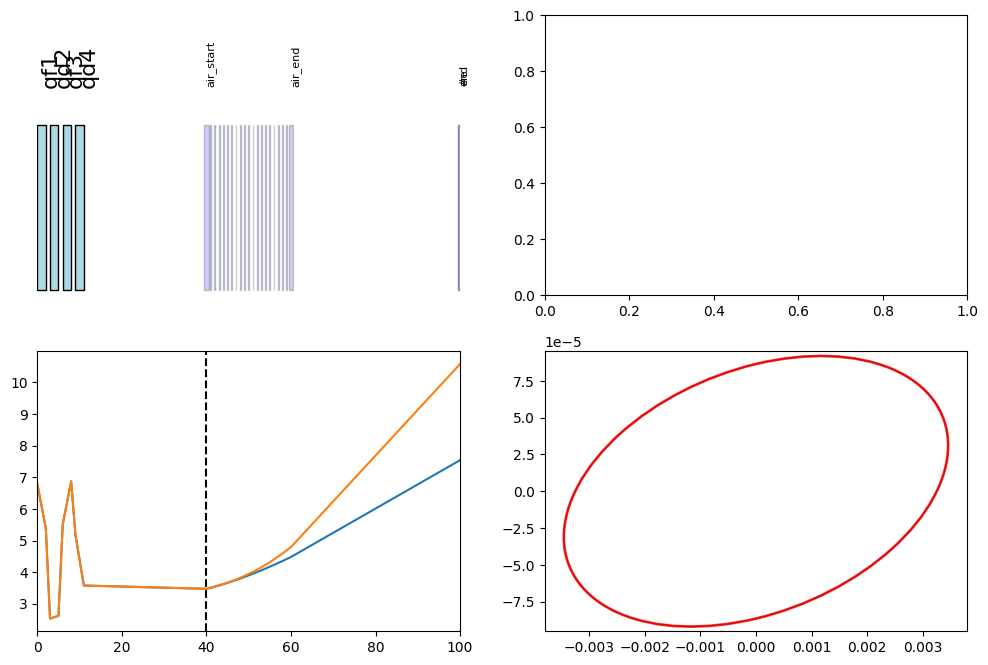

In [38]:
index = "air_start"
fig, ax = plt.subplots(2,2, figsize=(12, 8))

draw_synoptic(ax[0,0], twiss_scattered)
ax[1,0].plot(twiss.s, 1000*beam_size(twiss.betx, twiss.dx, twiss.ex, sige, 1), label='vaccum')
ax[1,0].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.betx, twiss_scattered.dx, twiss_scattered.ex, sige, 1), label='scattered')
ax[0,0].set_xlim(0, twiss.s[-1])
ax[1,0].set_xlim(0, twiss.s[-1])

ax[1,0].axvline(twiss.loc[index].s, color='black', linestyle='--')

draw_ellipse(twiss.loc[index].alfx, twiss.loc[index].betx, ex, x0 = (0,0), ax=ax[1,1], plot_kwargs={'linewidth':1})
draw_ellipse(twiss_scattered.loc[index].alfx, twiss_scattered.loc[index].betx, ex, x0 = (0,0), ax=ax[1,1], plot_kwargs={'color':'red'})
ax[1,1].autoscale_view()

In [18]:
# import imageio
# import os

# # List to store each image file name
# filenames = []

# start_processing = False
# for i, index in enumerate(twiss_scattered.index):
#     if index == 'hidden_marker0':
#         start_processing = True
#     if not start_processing:
#         continue

#     fig, ax = plt.subplots(2,2, figsize=(12, 8))
#     draw_synoptic(ax[0,0], twiss_scattered)
#     ax[1,0].plot(twiss.s, 1000*beam_size(twiss.betx, twiss.dx, twiss.ex, sige, 1), label='vaccum')
#     ax[1,0].plot(twiss_scattered.s, 1000*beam_size(twiss_scattered.betx, twiss_scattered.dx, twiss_scattered.ex, sige, 1), label='scattered')
#     ax[0,0].set_xlim(0, twiss.s[-1])
#     ax[1,0].set_xlim(0, twiss.s[-1])
#     ax[1,0].axvline(twiss.loc[index].s, color='black', linestyle='--')
#     draw_ellipse(twiss.loc[index].alfx, twiss.loc[index].betx, ex, x0 = (0,0), ax=ax[1,1], plot_kwargs={'linewidth':1})
#     draw_ellipse(twiss_scattered.loc[index].alfx, twiss_scattered.loc[index].betx, ex, x0 = (0,0), ax=ax[1,1], plot_kwargs={'color':'red'})
#     ax[1,1].set_xlim([-0.02, 0.02])  # change as per your needs
#     ax[1,1].set_ylim([-0.0005, 0.0005])  # change as per your needs
#     filename = f'image/{i}.png'
#     plt.savefig(filename)  # save each plot as a .png file
#     filenames.append(filename)
#     plt.close()  # close the figure

# # Make a gif from the images
# with imageio.get_writer('ellipse.gif', mode='I', duration=0.2, loop=0) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Remove files
# for filename in set(filenames):
#     os.remove(filename)


# Distribution from the twiss parameters

In [19]:
from pybt.tools.particles import *

In [20]:
number_of_particles = 50000
n_sigma = 5

distH = beam_distrib_norm(twiss.loc["end"].alfx, twiss.loc["end"].betx, twiss.loc["end"].ex, number_of_particles, n_sigma)
distV = beam_distrib_norm(twiss.loc["end"].alfy, twiss.loc["end"].bety, twiss.loc["end"].ey, number_of_particles, n_sigma)

x = distH[:, 0]
xp = distH[:, 1]
y = distV[:, 0]
yp = distV[:, 1]

distH_scattered = beam_distrib_norm(twiss_scattered.loc["end"].alfx, twiss_scattered.loc["end"].betx, twiss_scattered.loc["end"].ex, number_of_particles, n_sigma)
distV_scattered = beam_distrib_norm(twiss_scattered.loc["end"].alfy, twiss_scattered.loc["end"].bety, twiss_scattered.loc["end"].ey, number_of_particles, n_sigma)

x_scattered = distH_scattered[:, 0]
xp_scattered = distH_scattered[:, 1]
y_scattered = distV_scattered[:, 0]
yp_scattered = distV_scattered[:, 1]


(-0.02, 0.02)

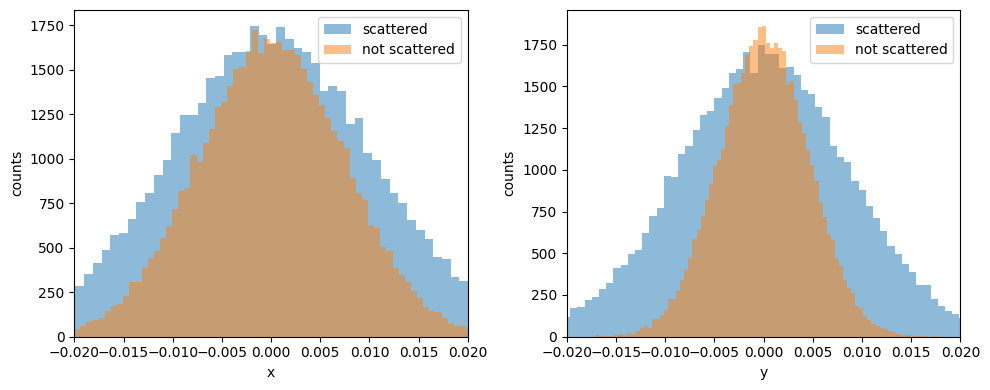

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), tight_layout=True)
ax[0].hist(x_scattered, alpha=0.5, label="scattered", bins=100)
ax[0].hist(x, alpha=0.5, label="not scattered", bins=100)
ax[0].set_xlabel("x")
ax[0].set_ylabel("counts")
ax[0].legend()
ax[0].set_xlim(-0.02, 0.02)

ax[1].hist(y_scattered, alpha=0.5, label="scattered", bins=100)
ax[1].hist(y, alpha=0.5, label="not scattered", bins=100)
ax[1].set_xlabel("y")
ax[1].set_ylabel("counts")
ax[1].legend()
ax[1].set_xlim(-0.02, 0.02)

Text(0.5, 0.98, 'Twiss scattering at the end of the lattice\n 50000 particles')

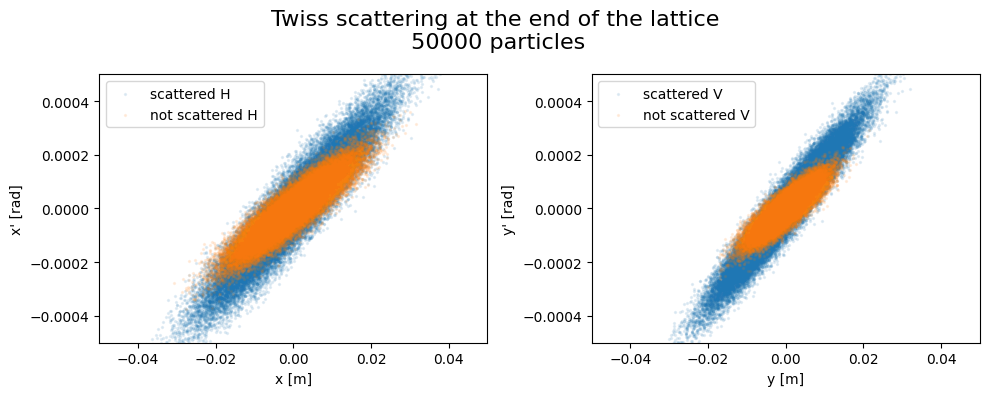

In [22]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].scatter(x_scattered, xp_scattered, alpha=0.1, s=2, label='scattered H')
ax[0].scatter(x, xp, alpha=0.1, s=2, label='not scattered H')
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('x\' [rad]')
ax[0].legend()
ax[0].set_xlim(-0.05, 0.05)
ax[0].set_ylim(-0.0005, 0.0005)


ax[1].scatter(y_scattered, yp_scattered, alpha=0.1, s=2, label='scattered V')
ax[1].scatter(y, yp, alpha=0.1, s=2, label='not scattered V')
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('y\' [rad]')
ax[1].legend()
ax[1].set_xlim(-0.05, 0.05)
ax[1].set_ylim(-0.0005, 0.0005)

fig.suptitle(f"Twiss scattering at the end of the lattice\n {number_of_particles} particles", fontsize=16)

## Pickle the data

In [23]:
d = {'x': x, 'xp': xp, 'y': y, 'yp': yp}
df_analytic_not_scattered = pd.DataFrame(data=d)

d = {'x': x_scattered, 'xp': xp_scattered, 'y': y_scattered, 'yp': yp_scattered}
df_analytic_scattered = pd.DataFrame(data=d)

In [24]:
import pickle
with open('data/df_analytic_scattered.pickle', 'wb') as handle:
    pickle.dump(df_analytic_scattered, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/df_analytic_not_scattered.pickle', 'wb') as handle:
    pickle.dump(df_analytic_not_scattered, handle, protocol=pickle.HIGHEST_PROTOCOL)


Text(0.5, 0.98, 'Twiss scattering at the end of the lattice\n 50000 particles')

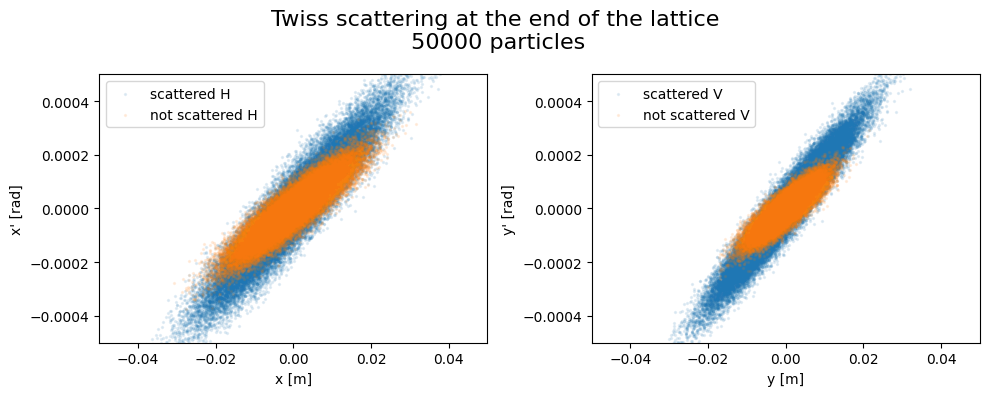

In [25]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].scatter(df_analytic_scattered.x, df_analytic_scattered.xp, alpha=0.1, s=2, label='scattered H')
ax[0].scatter(x, xp, alpha=0.1, s=2, label='not scattered H')
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('x\' [rad]')
ax[0].legend()
ax[0].set_xlim(-0.05, 0.05)
ax[0].set_ylim(-0.0005, 0.0005)


ax[1].scatter(y_scattered, yp_scattered, alpha=0.1, s=2, label='scattered V')
ax[1].scatter(y, yp, alpha=0.1, s=2, label='not scattered V')
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('y\' [rad]')
ax[1].legend()
ax[1].set_xlim(-0.05, 0.05)
ax[1].set_ylim(-0.0005, 0.0005)

fig.suptitle(f"Twiss scattering at the end of the lattice\n {number_of_particles} particles", fontsize=16)

# Twiss parameters at the end of the line

In [26]:
print(f"alfx analytical before = {round(twiss.loc['end'].alfx,2)} after = {round(twiss_scattered.loc['end'].alfx,2)}")
print(f"betx analytical before = {round(twiss.loc['end'].betx,2)} after = {round(twiss_scattered.loc['end'].betx,2)}")
print(f"ex analytical before = {round(twiss.loc['end'].ex,9)} after = {round(twiss_scattered.loc['end'].ex,9)}")


alfx analytical before = -2.06 after = -2.58
betx analytical before = 185.0 after = 167.3
ex analytical before = 2.99e-07 after = 6.59e-07


In [27]:
# find_best_ellipse(df_analytic_not_scattered.x, df_analytic_not_scattered.xp, twiss.loc['end'].alfx, twiss.loc['end'].betx, twiss.loc['end'].ex)

In [28]:
# find_best_ellipse(df_analytic_scattered.x, df_analytic_scattered.xp, twiss_scattered.loc['end'].alfx, twiss_scattered.loc['end'].betx, twiss_scattered.loc['end'].ex)

In [29]:
from madxtools.particles import *

betx_bef, alfx_bef, gamma_bef, ex_bef = twiss_parameters_from_distribution(df_analytic_not_scattered.x, df_analytic_not_scattered.xp)
betx_aft, alfx_aft, gamma_aft, ex_aft = twiss_parameters_from_distribution(df_analytic_scattered.x, df_analytic_scattered.xp)


print(f"alfx analytical before = {round(alfx_bef,2)} after = {round(alfx_aft,2)}")
print(f"betx analytical before = {round(betx_bef,2)} after = {round(betx_aft,2)}")
print(f"ex analytical before = {round(ex_bef,9)} after = {round(ex_aft,9)}")

bety_bef, alfy_bef, gamma_bef, ey_bef = twiss_parameters_from_distribution(df_analytic_not_scattered.y, df_analytic_not_scattered.yp)
bety_aft, alfy_aft, gamma_aft, ey_aft = twiss_parameters_from_distribution(df_analytic_scattered.y, df_analytic_scattered.yp)

print(f"alfy analytical before = {round(alfy_bef,2)} after = {round(alfy_aft,2)}")
print(f"bety analytical before = {round(bety_bef,2)} after = {round(bety_aft,2)}")
print(f"ey analytical before = {round(ey_bef,9)} after = {round(ey_aft,9)}")

alfx analytical before = -2.06 after = -2.57
betx analytical before = 185.27 after = 166.62
ex analytical before = 2.99e-07 after = 6.63e-07
alfy analytical before = -1.72 after = -3.23
bety analytical before = 149.85 after = 184.64
ey analytical before = 1.37e-07 after = 4.14e-07
